# 1. Packages

In [1]:
import datetime
import matplotlib.pyplot as plt

# PySpark packages
from pyspark.sql import SparkSession
from pyspark.sql.functions import (isnan,coalesce,col,lit,when)
from pyspark.sql.functions import (StringType,udf,datediff,date_add)
from pyspark.sql.types import (DoubleType,IntegerType,FloatType,DateType)
from pyspark.sql.functions import (countDistinct,monotonically_increasing_id)

# PySpark ML
from pyspark.ml.feature import (VectorAssembler,StringIndexer,StandardScaler,OneHotEncoder)
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression

In [2]:
spark = SparkSession.builder.appName("String").getOrCreate()

In [3]:
spark

# 2. The Dataset

In [4]:
loan = spark.read.csv('loan.csv', inferSchema = True, header = True)

In [5]:
# 107864 records and 116 columns.
print(loan.count())
print(len(loan.columns))

107864
116


# 3. Preprocessing 
- From the last notebook, LC_Data_Cleaning_(2), I did lots of preprocessing steps on the raw data such as generating meaningful datetime features and transforming incorrect data types into desired and corrrect data types.

## 3.1 From LC_Data_Cleaning_(2)

In [6]:
loan = loan.drop('pymnt_plan','sub_grade')
remove_space = udf(lambda x: x.strip(), StringType())
loan = loan.withColumn('term', remove_space('term'))

In [7]:
loan = loan.withColumn("issue_d", date_add("issue_d", -365))
loan = loan.withColumn('next_pymnt_d', 
                       when(loan.next_pymnt_d.isNotNull(), 
                            loan.next_pymnt_d).otherwise(datetime.datetime(9999,12,31)))
loan = loan.withColumn("diff_last_next_pymnt_d",
                       datediff(loan.next_pymnt_d, loan.last_pymnt_d))
loan = loan.withColumn("diff_next_pymnt_end_of_march_d",
                       datediff(loan.next_pymnt_d, lit(datetime.datetime(2019,3,31)))
                      )
loan = loan.withColumn("diff_last_pymnt_end_of_march_d",
                       datediff(loan.last_pymnt_d, lit(datetime.datetime(2019,3,31)))
                      )   
def transform_datetime(x):
    if x == datetime.date(2018, 1, 18):
        return 'issue_d_level_1'
    elif x == datetime.date(2018, 2, 18):
        return 'issue_d_level_2'
    elif x == datetime.date(2018, 3, 18):
        return 'issue_d_level_3'
    else:
        return 'issue_d_level_na'
trans_issue_d = udf(transform_datetime)
loan = loan.withColumn('issue_d', 
                       trans_issue_d(loan.issue_d))
loan = loan.withColumn("last_credit_pull_d", date_add("last_credit_pull_d", -365*2))
loan = loan.withColumn("earliest_cr_line", date_add("earliest_cr_line", -365))
loan = loan.withColumn("sec_app_earliest_cr_line", date_add("sec_app_earliest_cr_line", -365))
loan = loan.withColumn("diff_earliest_cr_line_end_of_march_d",
                       datediff(loan.earliest_cr_line, lit(datetime.datetime(2018,3,31)))
                      )
loan = loan.withColumn("diff_sec_app_earliest_cr_line_end_of_march_d",
                       datediff(loan.sec_app_earliest_cr_line, lit(datetime.datetime(2018,3,31)))
                      )
loan = loan.withColumn("diff_last_credit_pull_end_of_march_d",
                       datediff(loan.last_credit_pull_d, lit(datetime.datetime(2018,3,31)))
                      )
loan = loan.drop('last_pymnt_d','next_pymnt_d',
                 'last_credit_pull_d','earliest_cr_line','sec_app_earliest_cr_line'
                )                       

# 3.2 From LC_EDA
- As I did in the notebook, 'LC_EDA', for those categorical features with too many levels, I lowered down the levels into a smaller size by some initial data explorations.

In [10]:
columns_with_types = loan.dtypes
for each in columns_with_types:
    if each[1] == 'string' and loan.select(countDistinct(each[0])).collect()[0][0] <=10:
        continue
    elif each[1] == 'string':
        print('Need lowering down {} levels in {}.'.format(
            loan.select(countDistinct(each[0])).collect()[0][0],
            each[0]))

Need lowering down 37288 levels in emp_title.
Need lowering down 12 levels in emp_length.
Need lowering down 13 levels in purpose.
Need lowering down 50 levels in addr_state.


In [11]:
sqlCtx.registerDataFrameAsTable(loan, "table_loan")

### 3.2.1 emp_title

Text(0.5, 1.0, 'emp_title')

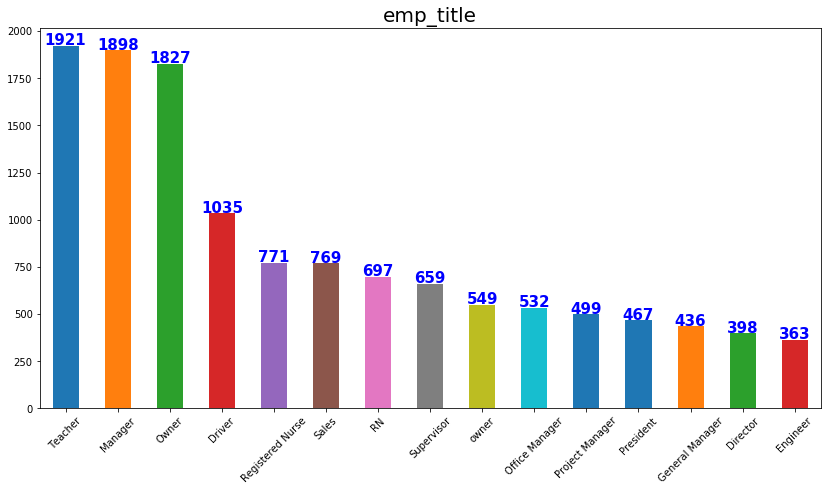

In [12]:
df1 = sqlCtx.sql("SELECT emp_title FROM table_loan")

fig = plt.figure(figsize=(14,7))
ax = df1.toPandas().emp_title.value_counts()[:15].plot(kind = 'bar', rot = 45)
for i, v in enumerate(df1.toPandas().emp_title.value_counts()[:15]):
    ax.text(i, v+5, str(v), color='blue', fontweight='bold', fontsize=15, ha='center')
ax.set_title('emp_title',fontsize=20)

In [13]:
del df1

In [14]:
# I decided to drop off 'emp_title' because 'emp_length' might reveal 
# a similar information on 'loan_status'
loan = loan.drop('emp_title')

### 3.2.2 Transform 'emp_length' into 'new_emp_length'

In [15]:
sqlCtx.registerDataFrameAsTable(loan, "table_loan")

In [16]:
# As I did in the notebook, LC_EDA', I lowered down 13 levels in emp_length 
# into 4 levels including 'junior', 'more_experienced', 'experienced', and 'na_experience'.
query_1 = "SELECT CASE WHEN emp_length IN ('< 1 year','1 year','2 years','3 years') THEN 'junior' \
WHEN emp_length IN ('4 years', '5 years') THEN 'more_experienced' \
WHEN emp_length IN ('n/a') THEN 'na_experience' \
ELSE 'experienced' END AS new_emp_length, * FROM table_loan"

In [17]:
loan = spark.sql(query_1)

# Make sure the transformation is correct!
loan.select('emp_length','new_emp_length').show(10)

# Then, drop off 'emp_length'.
loan = loan.drop('emp_length')

+----------+----------------+
|emp_length|  new_emp_length|
+----------+----------------+
| 10+ years|     experienced|
| 10+ years|     experienced|
| 10+ years|     experienced|
|   5 years|more_experienced|
| 10+ years|     experienced|
|   3 years|          junior|
|   4 years|more_experienced|
|   3 years|          junior|
| 10+ years|     experienced|
|       n/a|   na_experience|
+----------+----------------+
only showing top 10 rows



### 3.2.3 Transform 'purpose' into 'new_purpose'

In [18]:
sqlCtx.registerDataFrameAsTable(loan, "table_loan")

In [19]:
query_1 = "SELECT CASE WHEN purpose IN ('debt_consolidation') THEN 'debt_consolidation' \
WHEN purpose IN ('credit_card') THEN 'credit_card' \
WHEN purpose IN ('other') THEN 'other' \
WHEN purpose IN ('home_improvement','house','moving') THEN 'home' \
ELSE 'major_purchase' END AS new_purpose, * FROM table_loan"

In [20]:
loan = spark.sql(query_1)

# Make sure the transformation is correct!
loan.select('purpose','new_purpose').show(10)

# Then, drop off 'purpose'.
loan = loan.drop('purpose')

+------------------+------------------+
|           purpose|       new_purpose|
+------------------+------------------+
|debt_consolidation|debt_consolidation|
|             other|             other|
|debt_consolidation|debt_consolidation|
|       credit_card|       credit_card|
|debt_consolidation|debt_consolidation|
|debt_consolidation|debt_consolidation|
|debt_consolidation|debt_consolidation|
|  home_improvement|              home|
|       credit_card|       credit_card|
|debt_consolidation|debt_consolidation|
+------------------+------------------+
only showing top 10 rows



### 3.2.4 Transform 'addr_state' into 'new_addr_state'

In [21]:
sqlCtx.registerDataFrameAsTable(loan, "table_loan")

In [22]:
query_1 = "SELECT CASE WHEN addr_state IN ('WA','OR','ID','MT','WY','CA','NV','UT','CO','AK','HI') THEN 'west' \
WHEN addr_state IN ('ND','SD','NE','KS','MN','IA','MO','WI','IL','MI','IN','OH') THEN 'midwest' \
WHEN addr_state IN ('AZ','NM','OK','TX') THEN 'southwest' \
WHEN addr_state IN ('KY','WV', 'DC','VA','AR','LA','TN','NC','MS','AL','GA','SC','FL') THEN 'southeast' \
ELSE 'northeast'END AS new_addr_state, * FROM table_loan"

In [23]:
loan = spark.sql(query_1)

# Make sure the transformation is correct!
loan.select('addr_state','new_addr_state').show(10)

# Then, drop off 'addr_state'.
loan = loan.drop('addr_state')

+----------+--------------+
|addr_state|new_addr_state|
+----------+--------------+
|        IL|       midwest|
|        GA|     southeast|
|        CA|          west|
|        PA|     northeast|
|        VA|     southeast|
|        NV|          west|
|        NY|     northeast|
|        VA|     southeast|
|        NJ|     northeast|
|        IL|       midwest|
+----------+--------------+
only showing top 10 rows



In [24]:
# 114 columns left.
len(loan.columns)

114

# 4. Missing Data Imputation - Linear Regression with top three predictors

In [25]:
def missing_logistic_regression(dataframe, missing_column):
    '''
    dataframe: a pyspark dataframe.
    missing_column: a column name of a missing column.
    Outputs: Return the top three predictors that cause such missing values in the missing
    column estimated by Logistic Regression.
    '''
    # First, drop off missing columns in the dataframe.
    columns = dataframe.columns
    columns.remove(missing_column)
    
    for col in columns:
        count_missing = dataframe.filter(dataframe[col].isNull()).count()
        if count_missing != 0:
            dataframe = dataframe.drop(col)

    # Group missing data into two, 'NA' or 'NOT NA'.
    sqlCtx.registerDataFrameAsTable(dataframe, "dataframe")
    
    dataframe = sqlCtx.sql("SELECT CASE WHEN "+missing_column+ " IS NULL THEN 'NA'\
    ELSE 'NOT NA' END AS NA_OR_NOT_NA, * FROM dataframe")
    
    # Transform strings into numbers using StringIndexer.
    columns = dataframe.columns
    cate_columns = []
    for each in columns:
        if dataframe.select(each).dtypes[0][1] == 'string':
            cate_columns.append(each)

    for each in cate_columns:
        indexer = StringIndexer(inputCol=each, outputCol=each+"_cat")
        dataframe = indexer.fit(dataframe).transform(dataframe)
        dataframe = dataframe.drop(each)
        
    # LR modeling: preprocessing
    columns = dataframe.columns
    columns.remove(missing_column)
    columns.remove('NA_OR_NOT_NA_cat')
    
    # Assemble all the 'predictors' into a vector.
    assembler = VectorAssembler(inputCols=columns, outputCol="features")
    dataframe = assembler.transform(dataframe) 
    
    # Standardization to obtain 'fair' coefficient estimations.
    std_scaler = StandardScaler(inputCol="features", outputCol="scaled_features",\
                                withStd=True, withMean=True)
    dataframe = std_scaler.fit(dataframe).transform(dataframe)
    
    # LR modeling
    lr = LogisticRegression(featuresCol='scaled_features', 
                            labelCol='NA_OR_NOT_NA_cat', 
                            predictionCol='prediction')
    
    final_data = dataframe.select('scaled_features', 'NA_OR_NOT_NA_cat')
    lr_model = lr.fit(final_data)
    
    # Coefficient report
    coeffs = lr_model.coefficients.toArray()
    sorted_coeff_indexes = (abs(coeffs)).argsort()[-3:]
    top_three_features = []
    
    for index in sorted_coeff_indexes:
        top_three_features.append(columns[index])
    
    return top_three_features

## 4.1 Numerical features which contained missing values

In [26]:
missing_numeric_feat = []
columns = loan.columns
for each in columns:
    if loan.select(each).dtypes[0][1] != 'string':
        if loan.filter(loan[each].isNull()).count() != 0:
            missing_numeric_feat.append(each)

In [27]:
missing_numeric_feat_with_top_three = {}
for each in missing_numeric_feat:
    print('Processing column : {}.'.format(each))
    top_three_feats = missing_logistic_regression(dataframe=loan, 
                                                  missing_column=each)
    missing_numeric_feat_with_top_three[each] = top_three_feats

Processing column : dti.
Processing column : mths_since_last_delinq.
Processing column : mths_since_last_record.
Processing column : revol_util.
Processing column : mths_since_last_major_derog.
Processing column : mths_since_rcnt_il.
Processing column : il_util.
Processing column : all_util.
Processing column : avg_cur_bal.
Processing column : bc_open_to_buy.
Processing column : bc_util.
Processing column : mo_sin_old_il_acct.
Processing column : mths_since_recent_bc.
Processing column : mths_since_recent_bc_dlq.
Processing column : mths_since_recent_inq.
Processing column : mths_since_recent_revol_delinq.
Processing column : num_tl_120dpd_2m.
Processing column : pct_tl_nvr_dlq.
Processing column : percent_bc_gt_75.
Processing column : sec_app_revol_util.
Processing column : sec_app_mths_since_last_major_derog.
Processing column : diff_last_next_pymnt_d.
Processing column : diff_last_pymnt_end_of_march_d.
Processing column : diff_last_credit_pull_end_of_march_d.


## 4.2 Deal with categorical features which contained missing values

In [28]:
missing_cate_feat = []
columns = loan.columns
for each in columns:
    if loan.select(each).dtypes[0][1] == 'string':
        if loan.filter(loan[each].isNull()).count() != 0:
            missing_cate_feat.append(each)

In [29]:
missing_cate_feat

[]

# 5. Missing value imputation - Linear Regression

In [30]:
def linear_regression_missing_impute(dataframe, top_three_features, missing_feature):
    '''
    dataframe: a pyspark dataframe.
    top_three_features: a list object containing feature names found by the 
    missing_logistic_regression function.
    missing_feature: the target feature, or a missing column name.
    
    Output: predictions by Linear Regression on a missing column.
    '''
    # Preprocessing: transform categorical features into vectors containing numbers. 
    test_columns = []
    for each in top_three_features:
        if 'cat' in each:
            indexer = StringIndexer(inputCol=each.replace('_cat',''), 
                                    outputCol=each+'_index')
            dataframe = indexer.fit(dataframe).transform(dataframe)
            encoder = OneHotEncoder(inputCol=each+'_index', 
                                    outputCol=each+'_vec')
            dataframe = encoder.transform(dataframe)
            test_columns.append(each+'_vec')
        else:
            test_columns.append(each)  
        
    train_columns = test_columns+[missing_feature]  
    df_train = dataframe.filter(dataframe[missing_feature].isNotNull()).\
    select(train_columns)  
    
    # Feature vectorization.
    assembler = VectorAssembler(inputCols=test_columns, outputCol="features")
    df_train = assembler.transform(df_train)
    df_test = assembler.transform(dataframe.select(train_columns))
    
    # Linear Regression modeling.
    lr = LinearRegression(featuresCol='features',\
                          labelCol=missing_feature,\
                          predictionCol='prediction')
    
    # Predictions.
    fit_lr_model = lr.fit(df_train)
    preds = fit_lr_model.transform(df_test)
    preds = preds.select('prediction')
    
    # Output
    return preds

In [33]:
# Python version
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder

def py_linear_regression_missing_impute(dataframe, top_three_features, missing_feature):
    # Preprocessing: transform categorical features into vectors containing numbers.
    columns = []
    for each in top_three_features:
        if 'cat' in each:
            columns.append(each.replace('_cat',''))
        else:
            columns.append(each) 
            
    df = dataframe.select(columns+[missing_feature]) 
    df = df.toPandas()
    
    # Dummy features
    dummy_features = []
    binary_features = []
    for each in df.columns:
        if df[each].dtype == 'object':
            if len(df[each].unique()) > 2:
                dummy_features.append(each)
            else: 
                binary_features.append(each)
            
    # One-hot encoding for categorical features containing two levels.
    le = LabelEncoder()

    for col in binary_features:
        le.fit(df[col])
        df[col] = le.transform(df[col])

    df = pd.get_dummies(df, columns = dummy_features)   
    
    # Training data
    train_df = df[~df[missing_feature].isnull()]
    
    # Modeling
    lr = linear_model.LinearRegression()
    lr.fit(train_df[columns], train_df[missing_feature])
    
    # Predictions
    pred = lr.predict(df[columns])
    
    return pred

In [34]:
def replace_null(orig, ma):
    return when(orig.isNull(), ma).otherwise(orig)

In [38]:
test_df = loan

In [ ]:
loan=loan.withColumn('row_index', monotonically_increasing_id())
for each in missing_numeric_feat_with_top_three:
    print('Missing data imputation processing: {}.'.format(each))
    pred = py_linear_regression_missing_impute(loan,
                                               missing_numeric_feat_with_top_three[each],
                                               each)
    pred_df = spark.createDataFrame(pd.DataFrame(pred),schema=['prediction'])
    pred_df = pred_df.withColumn('row_index', monotonically_increasing_id())
    loan = loan.join(pred_df, 
                     on=["row_index"]).sort("row_index")
    loan = loan.withColumn('imputed_'+each, 
                           replace_null(col(each), col('prediction'))
                          )
    loan = loan.drop('prediction')
    # Inspect the imputation process: the values of two columns 'must' be the same.
    loan.filter(loan[each].isNotNull()).select(['imputed_'+each,each]).show(5)
    loan = loan.drop(each)
loan = loan.drop('row_index')

In [ ]:
import numpy as np
from fancyimpute import (
    BiScaler,
    KNN,
    IterativeImputer,
    NuclearNormMinimization,
    SoftImpute,
    SimpleFill
)

n = 200
m = 20
inner_rank = 4
X = np.dot(np.random.randn(n, inner_rank), np.random.randn(inner_rank, m))
print("Mean squared element: %0.4f" % (X ** 2).mean())

# X is a data matrix which we're going to randomly drop entries from
missing_mask = np.random.rand(*X.shape) < 0.1
X_incomplete = X.copy()
# missing entries indicated with NaN
X_incomplete[missing_mask] = np.nan

meanFill = SimpleFill("mean")
X_filled_mean = meanFill.fit_transform(X_incomplete)

# Model each feature with missing values as a function of other features, and
# use that estimate for imputation.
X_filled_ii = IterativeImputer().fit_transform(X_incomplete)

# Use 3 nearest rows which have a feature to fill in each row's missing features
knnImpute = KNN(k=3)
X_filled_knn = knnImpute.fit_transform(X_incomplete)

# matrix completion using convex optimization to find low-rank solution
# that still matches observed values. Slow!
X_filled_nnm = NuclearNormMinimization().fit_transform(X_incomplete)

# Instead of solving the nuclear norm objective directly, instead
# induce sparsity using singular value thresholding
softImpute = SoftImpute()

# simultaneously normalizes the rows and columns of your observed data,
# sometimes useful for low-rank imputation methods
biscaler = BiScaler()

# rescale both rows and columns to have zero mean and unit variance
X_incomplete_normalized = biscaler.fit_transform(X_incomplete)

X_filled_softimpute_normalized = softImpute.fit_transform(X_incomplete_normalized)
X_filled_softimpute = biscaler.inverse_transform(X_filled_softimpute_normalized)

X_filled_softimpute_no_biscale = softImpute.fit_transform(X_incomplete)

meanfill_mse = ((X_filled_mean[missing_mask] - X[missing_mask]) ** 2).mean()
print("meanFill MSE: %f" % meanfill_mse)

# print mean squared error for the four imputation methods above
# print mean squared error for the three imputation methods above
ii_mse = ((X_filled_ii[missing_mask] - X[missing_mask]) ** 2).mean()
print("Iterative Imputer norm minimization MSE: %f" % ii_mse)

nnm_mse = ((X_filled_nnm[missing_mask] - X[missing_mask]) ** 2).mean()
print("Nuclear norm minimization MSE: %f" % nnm_mse)

softImpute_mse = ((X_filled_softimpute[missing_mask] - X[missing_mask]) ** 2).mean()
print("SoftImpute MSE: %f" % softImpute_mse)

softImpute_no_biscale_mse = (
    (X_filled_softimpute_no_biscale[missing_mask] - X[missing_mask]) ** 2).mean()
print("SoftImpute without BiScale MSE: %f" % softImpute_no_biscale_mse)


knn_mse = ((X_filled_knn[missing_mask] - X[missing_mask]) ** 2).mean()
print("knnImpute MSE: %f" % knn_mse)